# Week 2 - Exploratory Data Analysis and Plotting


In [50]:
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# This prevents pandas from showing weird warnings
pd.options.mode.chained_assignment = None

Let's pick up where we left from in Week 1 - I will take the query from last week's notebook and paste it in here. This is the only time we'll be using duckdb in this lecture.

In [2]:
df = duckdb.sql(
    """
        WITH attendance AS (
            SELECT
                report_period,
                school_code,
                student_class,
                subject_code,
                electronic_diary,
                FIRST(student_count_diary) student_count_diary,
                SUM(excused_lessons_illness) excused_lessons_illness,
                SUM(excused_lessons_other) excused_lessons_other,
                SUM(unexcused_lessons) unexcused_lessons
            FROM 'attendance/attendance.parquet'
            WHERE division_code IS NULL
            GROUP BY all
        ),
            school AS (
            SELECT 
                school_code, 
                school_name, 
                municipality_name
            FROM 'attendance/school.parquet' 
            WHERE division_code IS NULL
        ),
            subject AS (
            SELECT
                electronic_diary,
                subject_code,
                subject_name_en,
            FROM 'attendance/subject.parquet'
        )
        SELECT
            school.school_name,
            school.school_code,
            school.municipality_name,
            attendance.student_class,
            attendance.report_period,
            subject.subject_name_en,
            FIRST(attendance.student_count_diary) AS student_count,
            SUM(attendance.excused_lessons_illness) AS excused_lessons_illness,
            SUM(attendance.excused_lessons_other) AS excused_lessons_other,
            SUM(attendance.unexcused_lessons) AS unexcused_lessons
        FROM attendance
        JOIN school ON attendance.school_code = school.school_code
        JOIN subject ON attendance.subject_code = subject.subject_code
            AND attendance.electronic_diary = subject.electronic_diary
        GROUP BY all
""").df()


There's one weird thing I noticed about the attendance dataset.


In [3]:
df[
    (df["school_name"].str.contains("Vilniaus Užupio"))
    & (df["student_class"] == 12)
    & (df["report_period"] == "2019-01-01")
].head(5)

,school_name,school_code,municipality_name,student_class,report_period,subject_name_en,student_count,excused_lessons_illness,excused_lessons_other,unexcused_lessons
190638,Vilniaus Užupio gimnazija,190001124,Vilniaus m. sav.,12,2019-01-01,Psychology,152,18.0,4.0,20.0
193538,Vilniaus Užupio gimnazija,190001124,Vilniaus m. sav.,12,2019-01-01,... (elective),152,25.0,3.0,36.0
527749,Vilniaus Užupio gimnazija,190001124,Vilniaus m. sav.,12,2019-01-01,"Foreign language (first, German)",152,34.0,27.0,19.0
535438,Vilniaus Užupio gimnazija,190001124,Vilniaus m. sav.,12,2019-01-01,History,152,133.0,18.0,97.0
807365,Vilniaus Užupio gimnazija,190001124,Vilniaus m. sav.,12,2019-01-01,Physics,152,42.0,15.0,29.0


Above I filtered on every dimension except `period` and `subject_name_en`. What we see is that different subjects have exactly the same student count. In other words, the student count is on the class, and not the subject, level. This is sad news because this renders the dataset way less useful. For instance, we cannot compare e.g. `excused_lessons_illness / student_count` between different subjects, because this ratio might differ due to several reasons:
- different number of students that take this subject.
- different number of students have excused lessons.

Therefore, the rest of analysis uses just Mathematics as the subject.


In [4]:
df = df[(df["subject_name_en"] == "Mathematics") & (df["student_class"] == 12)]

There's another thing - I know I will be making a lot of plots that compare attendance numbers across time. However, the set of schools in the dataset is not uniform across time.

<Axes: xlabel='report_period'>

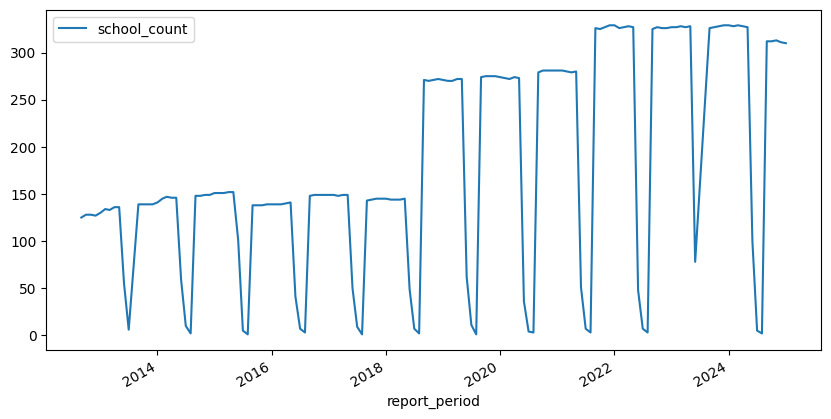

In [5]:
df.groupby("report_period").agg(school_count=("school_name", "nunique")).plot.line(
    y="school_count", figsize=(10, 5)
)

Now there is one issue here - will be comparing attendance numbers between years, but we won't be comparing apples to apples. Imagine we're comparing attendance between 2021 and 2022 and see big differences - are these differences there because something changed in the environment (quarantine, flu season, good weather), or because a bunch of new schools started using electronic diaries in 2022 and these schools also happen to have different attendance trends?

Overall, there's three things I want to do:
- Filter the dataset to be only for the period 2018-09-01 to 2024-05-31. 2018 September because that's when a bunch of new schools appeared in the dataset, 2024 May because that's when the 2023-2024 school year ended, and for 2024-2025 we don't have a full school year yet.
- We have to make sure that the set of schools is the same across the years.
- Get rid of summer months (nothing happens there)


In [43]:
# Filter on report period
df = df[df["report_period"].between("2018-09-01", "2024-05-31")]

In [42]:
# Get rid of summer months
df["month"] = df["report_period"].dt.month
df = df[~df["month"].isin([6, 7, 8])]

In [46]:
# Make sure the set of schools is the same across the years

# First, count how many report periods each school has
schools = df.groupby("school_name").agg(
    report_period_count=("report_period", "nunique")
)

# Then, filter on the schools that have data for all 6 school years (9 months each year)
schools = schools[schools["report_period_count"] == 6 * 9]
df = df[df["school_name"].isin(schools.index)]

<Axes: xlabel='report_period'>

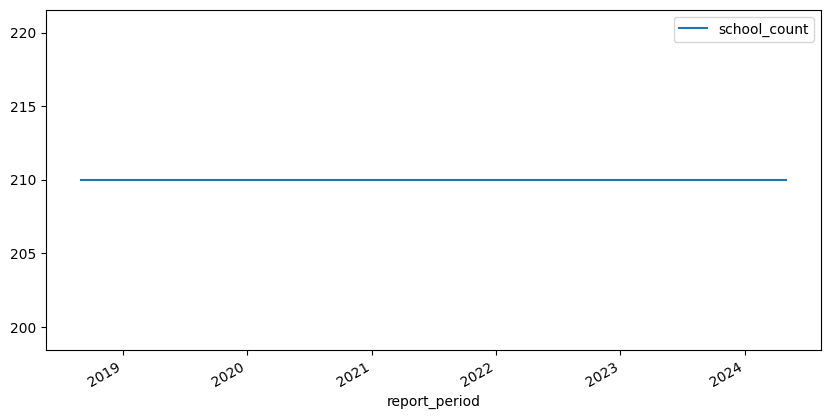

In [45]:
# Let's validate by plotting the number of schools over time
df.groupby("report_period").agg(school_count=("school_name", "nunique")).plot.line(
    y="school_count", figsize=(10, 5)
)

There's one last thing I want to do - we're analysing school information, therefore we need a `school_year` column - a column whose value only changes once `report_period` reaches September.

In [48]:
df["school_year"] = df["report_period"].dt.year - (
    df["report_period"].dt.month <= 5
).astype(int)
df[["report_period", "school_year"]].sample(5)

,report_period,school_year
4612547,2020-11-01,2020
1198725,2020-04-01,2019
409962,2021-12-01,2021
1749052,2022-11-01,2022
79584,2024-01-01,2023


Notice above how for report period 2020-04-01, school year is 2019 - which is what we want, because that's the school year beginning on year 2019.

Ok, let's begin our analysis now. It's important to keep in mind that our analysis is specifically about:
- 12th grade
- mathematics
- school year (excl. summer months)
- the 210 schools that were in the dataset between school years 2018 to 2022


Now I'm thinking in advance what kind of plots I will want to make. I will want to make plots of the `student_count`, `excused_lessons_illness`, and so on columns, but in their raw form they're less interesting, instead it would be better to look at their ratios:
- `excused_lessons_illness` / `student_count`
- `excused_lessons_other` / `student_count`
- `unexcused_lessons_other` / `student_count`
- (sum of all three columns) / `student_count`

Let's create these columns now.


In [49]:
df["excused_illness_per_student"] = df["excused_lessons_illness"] / df["student_count"]
df["excused_other_per_student"] = df["excused_lessons_other"] / df["student_count"]
df["unexcused_per_student"] = df["unexcused_lessons"] / df["student_count"]
df["total_missed"] = (
    df["excused_lessons_illness"]
    + df["excused_lessons_other"]
    + df["unexcused_lessons"]
)
df["total_missed_per_student"] = df["total_missed"] / df["student_count"]

df.sample(5)

,school_name,school_code,municipality_name,student_class,report_period,subject_name_en,student_count,excused_lessons_illness,excused_lessons_other,unexcused_lessons,month,school_year,excused_illness_per_student,excused_other_per_student,unexcused_per_student,total_missed,total_missed_per_student,year
3030694,Prienų r. Stakliškių gimnazija,190192277,Prienų r. sav.,12,2024-05-01,Mathematics,8,2.0,0.0,0.0,5,2023,0.250000,0.000000,0.000000,2.0,0.250000,2024
708693,Varėnos r. Valkininkų gimnazija,190109662,Varėnos r. sav.,12,2021-05-01,Mathematics,15,0.0,0.0,0.0,5,2020,0.000000,0.000000,0.000000,0.0,0.000000,2021
2894141,Alytaus r. Daugų Vlado Mirono gimnazija,190244044,Alytaus r. sav.,12,2022-11-01,Mathematics,13,7.0,10.0,0.0,11,2022,0.538462,0.769231,0.000000,17.0,1.307692,2022
4547030,Vilniaus Antakalnio gimnazija,302817872,Vilniaus m. sav.,12,2019-10-01,Mathematics,127,200.0,18.0,92.0,10,2019,1.574803,0.141732,0.724409,310.0,2.440945,2019
3329693,Jurbarko r. Veliuonos Antano ir Jono Juškų gim...,190919036,Jurbarko r. sav.,12,2020-03-01,Mathematics,39,54.0,1.0,0.0,3,2019,1.384615,0.025641,0.000000,55.0,1.410256,2020


## lineplots

Lineplots are for visualizing time series.

Let's begin with something very simple - a single school.


In [51]:
df_uzupis = df[(df["school_name"].str.contains("Vilniaus Užupio"))]  # My school
df_uzupis.sample(5)

,school_name,school_code,municipality_name,student_class,report_period,subject_name_en,student_count,excused_lessons_illness,excused_lessons_other,unexcused_lessons,month,school_year,excused_illness_per_student,excused_other_per_student,unexcused_per_student,total_missed,total_missed_per_student,year
3136745,Vilniaus Užupio gimnazija,190001124,Vilniaus m. sav.,12,2024-02-01,Mathematics,154,124.0,7.0,70.0,2,2023,0.805195,0.045455,0.454545,201.0,1.305195,2024
3390902,Vilniaus Užupio gimnazija,190001124,Vilniaus m. sav.,12,2021-02-01,Mathematics,133,13.0,1.0,79.0,2,2020,0.097744,0.007519,0.593985,93.0,0.699248,2021
3475151,Vilniaus Užupio gimnazija,190001124,Vilniaus m. sav.,12,2021-10-01,Mathematics,156,318.0,104.0,97.0,10,2021,2.038462,0.666667,0.621795,519.0,3.326923,2021
218473,Vilniaus Užupio gimnazija,190001124,Vilniaus m. sav.,12,2022-11-01,Mathematics,146,141.0,34.0,57.0,11,2022,0.965753,0.232877,0.390411,232.0,1.589041,2022
3241443,Vilniaus Užupio gimnazija,190001124,Vilniaus m. sav.,12,2022-03-01,Mathematics,153,187.0,12.0,173.0,3,2021,1.222222,0.078431,1.130719,372.0,2.431373,2022


<Axes: xlabel='report_period'>

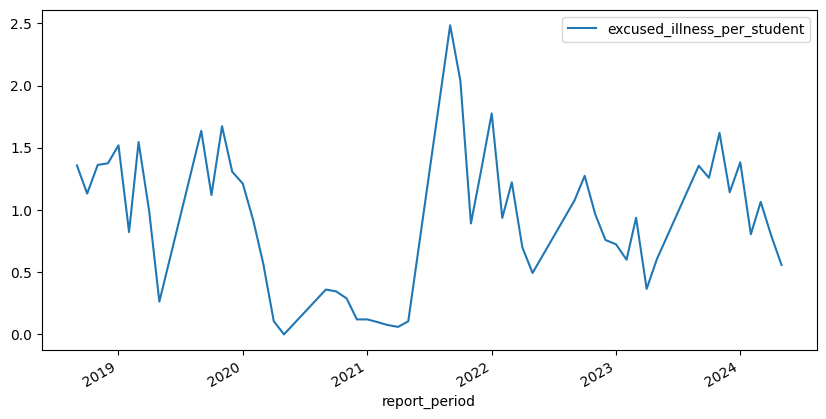

In [52]:
df_uzupis.sort_values(by="report_period").plot.line(
    x="report_period", y="excused_illness_per_student", figsize=(10, 5)
)

<Axes: xlabel='report_period'>

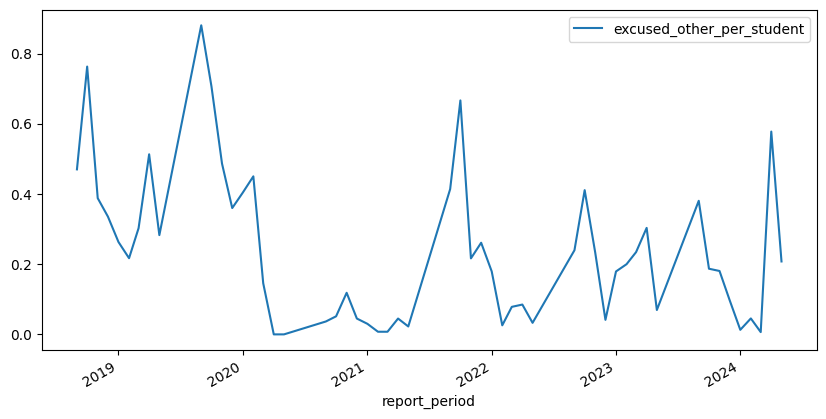

In [53]:
df_uzupis.sort_values(by="report_period").plot.line(
    x="report_period", y="excused_other_per_student", figsize=(10, 5)
)

<Axes: xlabel='report_period'>

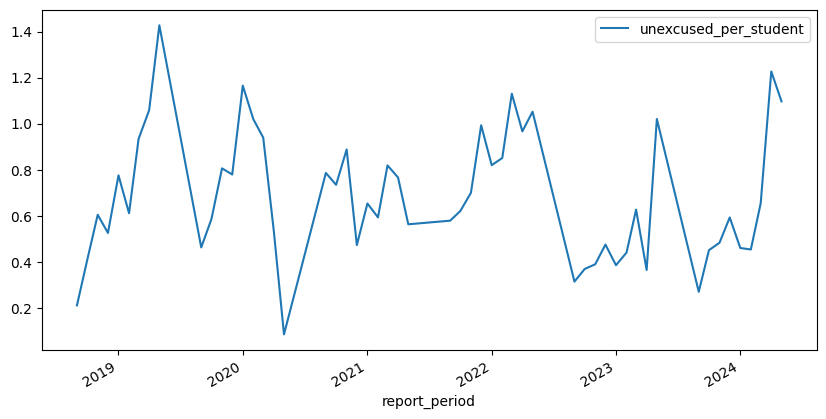

In [54]:
df_uzupis.sort_values(by="report_period").plot.line(
    x="report_period", y="unexcused_per_student", figsize=(10, 5)
)

Is there a more concise way to display the same information, both in terms of code and the number of plots?

<Axes: xlabel='report_period', ylabel='excused_illness_per_student'>

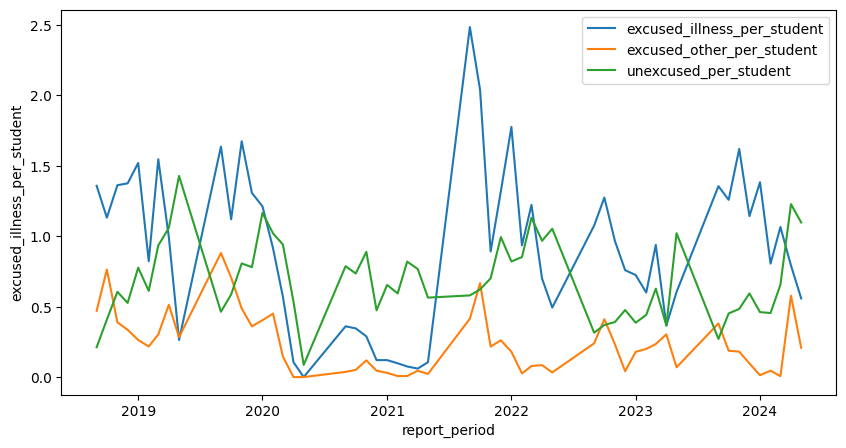

In [55]:
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=df_uzupis,
    x="report_period",
    y="excused_illness_per_student",
    label="excused_illness_per_student",
)
sns.lineplot(
    data=df_uzupis,
    x="report_period",
    y="excused_other_per_student",
    label="excused_other_per_student",
)
sns.lineplot(
    data=df_uzupis,
    x="report_period",
    y="unexcused_per_student",
    label="unexcused_per_student",
)

We are repeating ourselves - executing the same line of code except for the name of the column in the dataframe. 

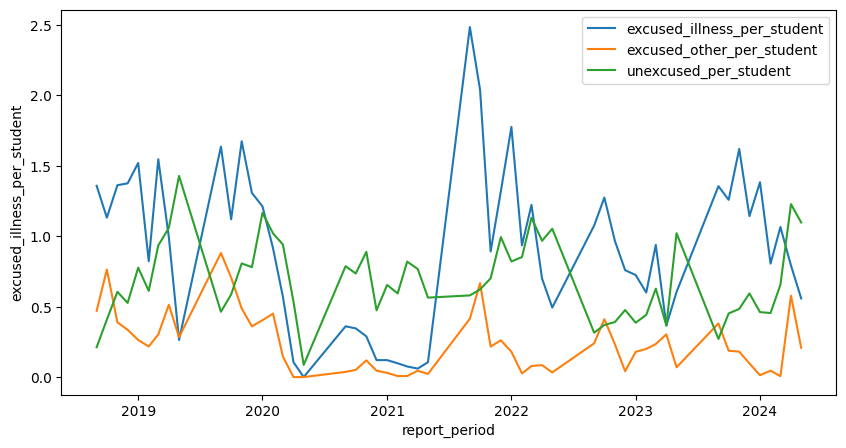

In [56]:
plt.figure(figsize=(10, 5))
columns = [
    "excused_illness_per_student",
    "excused_other_per_student",
    "unexcused_per_student",
]
for column in columns:
    sns.lineplot(
        data=df_uzupis,
        x="report_period",
        y=column,
        label=column,  # linestyle="--"
    )

Lesson one for today - don't repeat yourself. If you're making multiple plots of the same kind while just changing one variable or one column name, use a for loop.

We've reduced the dataset to just the time dimension, now let's add dimensions by keeping more schools in the dataframe.


In [59]:
df_three_schools = df[
    (
        df["school_name"].str.contains("Vilniaus Užupio")
        | df["school_name"].str.contains("Vilniaus Antakalnio")
        | df["school_name"].str.contains("Vilniaus Gabijos")
    )
]
df_three_schools.sample(5)

,school_name,school_code,municipality_name,student_class,report_period,subject_name_en,student_count,excused_lessons_illness,excused_lessons_other,unexcused_lessons,month,school_year,excused_illness_per_student,excused_other_per_student,unexcused_per_student,total_missed,total_missed_per_student,year
4345130,Vilniaus Gabijos gimnazija,305607530,Vilniaus m. sav.,12,2023-10-01,Mathematics,171,184.0,22.0,25.0,10,2023,1.076023,0.128655,0.146199,231.0,1.350877,2023
4442253,Vilniaus Gabijos gimnazija,190003513,Vilniaus m. sav.,12,2018-09-01,Mathematics,128,215.0,14.0,12.0,9,2018,1.679688,0.109375,0.093750,241.0,1.882812,2018
176818,Vilniaus Užupio gimnazija,190001124,Vilniaus m. sav.,12,2018-10-01,Mathematics,152,172.0,116.0,62.0,10,2018,1.131579,0.763158,0.407895,350.0,2.302632,2018
3503350,Vilniaus Antakalnio gimnazija,302817872,Vilniaus m. sav.,12,2023-11-01,Mathematics,149,236.0,18.0,35.0,11,2023,1.583893,0.120805,0.234899,289.0,1.939597,2023
1258567,Vilniaus Antakalnio gimnazija,302817872,Vilniaus m. sav.,12,2021-03-01,Mathematics,108,32.0,5.0,103.0,3,2020,0.296296,0.046296,0.953704,140.0,1.296296,2021


<Axes: xlabel='report_period', ylabel='excused_illness_per_student'>

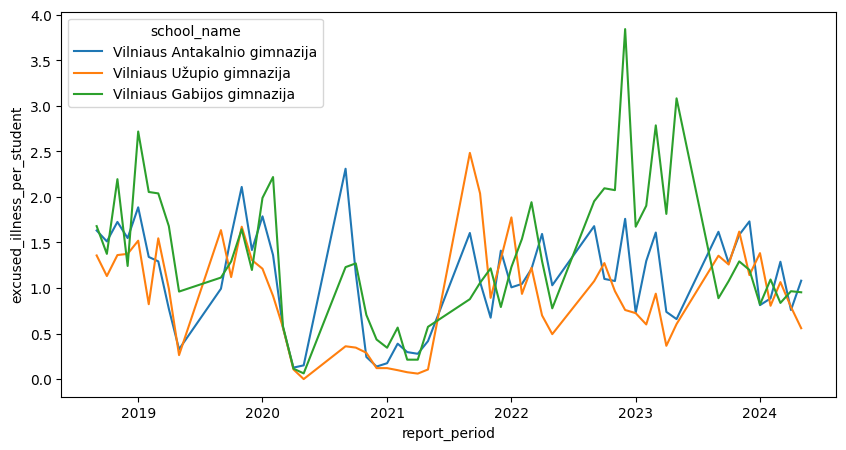

In [60]:
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=df_three_schools,
    x="report_period",
    y="excused_illness_per_student",
    hue="school_name",
)

You'll see a repetitive pattern in seaborn - pretty much all plots will have `data`, `x` and `y` parameters (kind of obvious). Also plots for which it makes sense will have the `hue` parameter which allows to create multiple plots on the same canvas for each value of a categorical variable.

## Histograms


In [61]:
df_2019_oct = df[(df["school_year"] == 2019) & (df["month"] == 10)]

<Axes: xlabel='total_missed_per_student', ylabel='Count'>

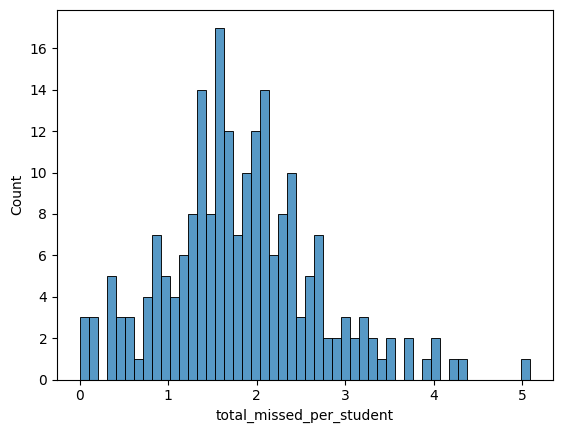

In [62]:
sns.histplot(
    data=df_2019_oct,
    x="total_missed_per_student",
    bins=50,
    # stat="probability",
    # cumulative=True
)

<Axes: xlabel='total_missed_per_student', ylabel='Probability'>

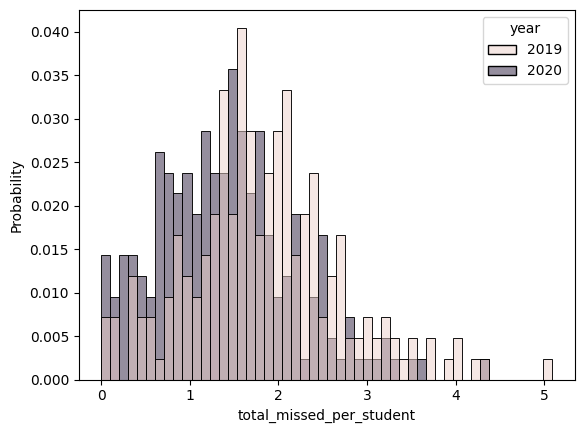

In [63]:
df_2019_2020_oct = df[(df["month"].isin([10])) & (df["year"].isin([2019, 2020]))]

sns.histplot(
    data=df_2019_2020_oct,
    x="total_missed_per_student",
    bins=50,
    stat="probability",
    hue="year",
)

This plot is difficult to read. Usually if we want to plot two distributions one over another, it's best to use densities.


<Axes: xlabel='total_missed_per_student', ylabel='Density'>

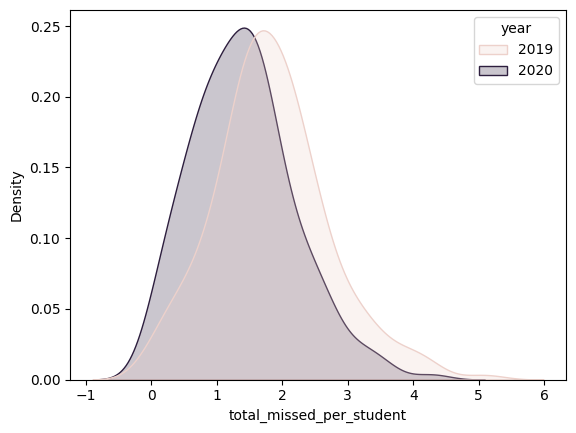

In [64]:
sns.kdeplot(
    data=df_2019_2020_oct,
    x="total_missed_per_student",
    hue="year",
    fill=True,
    # palette="Set2", # https://seaborn.pydata.org/tutorial/color_palettes.html
    # common_norm=False
)

<Axes: xlabel='total_missed_per_student', ylabel='Density'>

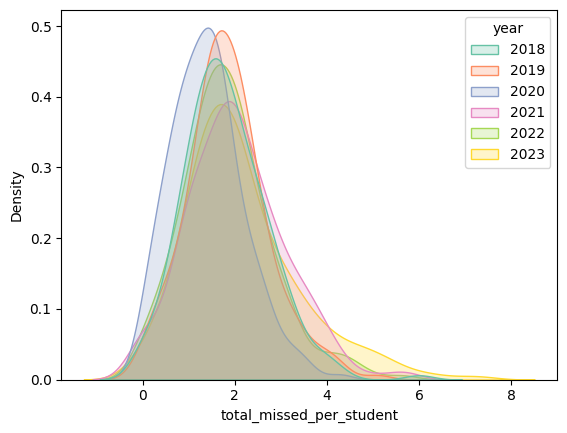

In [65]:
# df_12_all_years = df_12[df_12["year"].isin([2019, 2020, 2021, 2022, 2023, 2024])]
# Better
df_oct_all_years = df[df["month"] == 10]

sns.kdeplot(
    data=df_oct_all_years,
    x="total_missed_per_student",
    hue="year",
    fill=True,
    palette="Set2",
    common_norm=False,
)

## Barplots


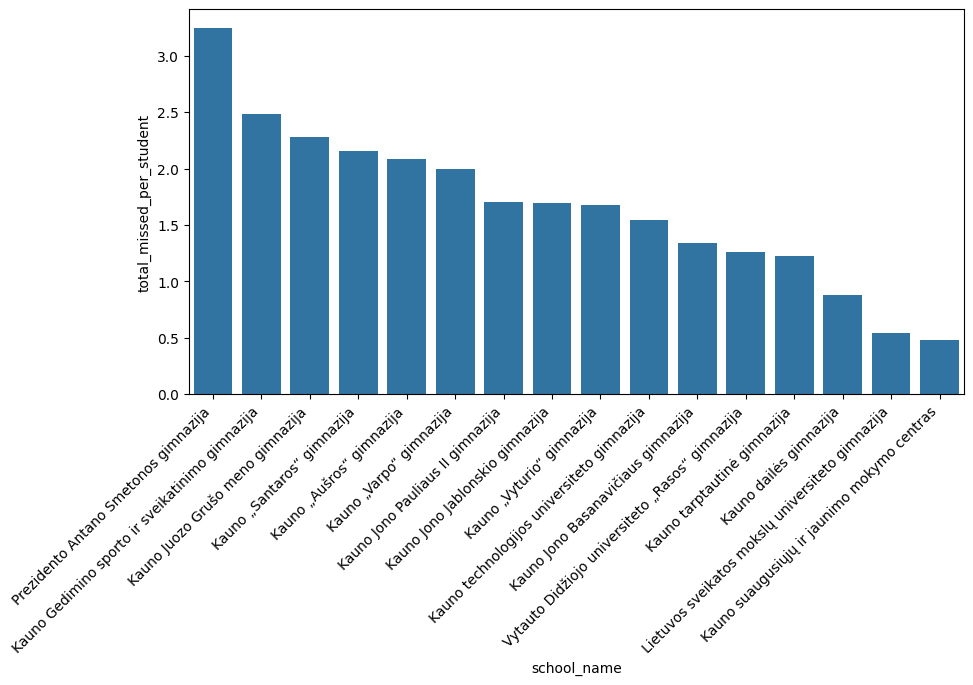

In [66]:
plt.figure(figsize=(10, 5))
df_kaunas_oct_2019 = df[
    (df["municipality_name"] == "Kauno m. sav.")
    & (df["month"] == 10)
    & (df["year"] == 2019)
]
ax = sns.barplot(
    data=df_kaunas_oct_2019,
    x="school_name",
    y="total_missed_per_student",
    order=df_kaunas_oct_2019.sort_values(
        by="total_missed_per_student", ascending=False
    )["school_name"],
)
plt.xticks(rotation=45, ha="right");

Personally, I don't often use barplots, because the information can be more easily displayed as a table

## Tables


In [67]:
df_kaunas_oct_2019[["school_name", "total_missed_per_student"]]

,school_name,total_missed_per_student
409248,Kauno suaugusiųjų ir jaunimo mokymo centras,0.478873
697532,Vytauto Didžiojo universiteto „Rasos“ gimnazija,1.258621
782442,Kauno Gedimino sporto ir sveikatinimo gimnazija,2.487805
973867,Kauno Jono Basanavičiaus gimnazija,1.341667
1340913,Kauno Jono Pauliaus II gimnazija,1.705882
1743030,Kauno Jono Jablonskio gimnazija,1.696000
1874034,Kauno Juozo Grušo meno gimnazija,2.282828
2465361,Kauno dailės gimnazija,0.880952
2830244,Kauno „Santaros“ gimnazija,2.158537
3041037,Lietuvos sveikatos mokslų universiteto gimnazija,0.542373


In [68]:
# Create a styled DataFrame with conditional formatting
df_styled = df_kaunas_oct_2019[
    ["school_name", "total_missed_per_student"]
].style.background_gradient()
df_styled

,school_name,total_missed_per_student
409248,Kauno suaugusiųjų ir jaunimo mokymo centras,0.478873
697532,Vytauto Didžiojo universiteto „Rasos“ gimnazija,1.258621
782442,Kauno Gedimino sporto ir sveikatinimo gimnazija,2.487805
973867,Kauno Jono Basanavičiaus gimnazija,1.341667
1340913,Kauno Jono Pauliaus II gimnazija,1.705882
1743030,Kauno Jono Jablonskio gimnazija,1.696000
1874034,Kauno Juozo Grušo meno gimnazija,2.282828
2465361,Kauno dailės gimnazija,0.880952
2830244,Kauno „Santaros“ gimnazija,2.158537
3041037,Lietuvos sveikatos mokslų universiteto gimnazija,0.542373


In [69]:
# Create a styled DataFrame with conditional formatting
columns = [
    "total_missed_per_student",
    "excused_illness_per_student",
    "excused_other_per_student",
    "unexcused_per_student",
]
df_styled = df_kaunas_oct_2019[["school_name"] + columns].style.background_gradient(
    axis=0  # 1, None
)
df_styled

,school_name,total_missed_per_student,excused_illness_per_student,excused_other_per_student,unexcused_per_student
409248,Kauno suaugusiųjų ir jaunimo mokymo centras,0.478873,0.000000,0.000000,0.478873
697532,Vytauto Didžiojo universiteto „Rasos“ gimnazija,1.258621,1.099138,0.090517,0.068966
782442,Kauno Gedimino sporto ir sveikatinimo gimnazija,2.487805,1.195122,1.292683,0.000000
973867,Kauno Jono Basanavičiaus gimnazija,1.341667,0.658333,0.683333,0.000000
1340913,Kauno Jono Pauliaus II gimnazija,1.705882,1.000000,0.705882,0.000000
1743030,Kauno Jono Jablonskio gimnazija,1.696000,1.128000,0.568000,0.000000
1874034,Kauno Juozo Grušo meno gimnazija,2.282828,1.979798,0.272727,0.030303
2465361,Kauno dailės gimnazija,0.880952,0.500000,0.380952,0.000000
2830244,Kauno „Santaros“ gimnazija,2.158537,1.195122,0.963415,0.000000
3041037,Lietuvos sveikatos mokslų universiteto gimnazija,0.542373,0.542373,0.000000,0.000000


## Scatterplots


<Axes: xlabel='excused_other_per_student', ylabel='excused_illness_per_student'>

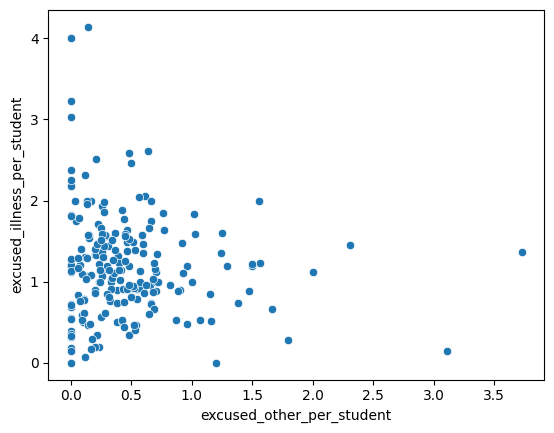

In [70]:
sns.scatterplot(
    data=df_2019_oct,
    x="excused_other_per_student",
    y="excused_illness_per_student",
)

<Axes: xlabel='excused_other_per_student', ylabel='excused_illness_per_student'>

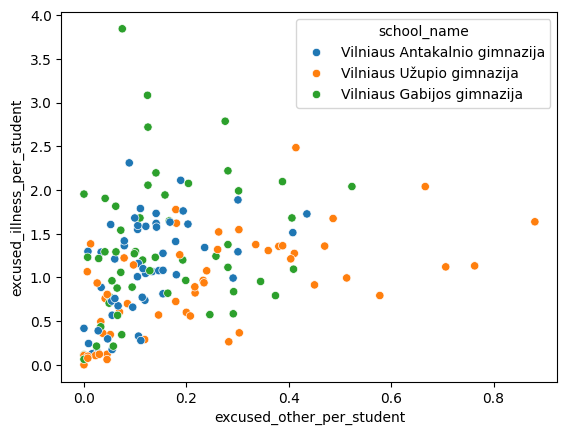

In [71]:
sns.scatterplot(
    data=df_three_schools,
    x="excused_other_per_student",
    y="excused_illness_per_student",
    hue="school_name",
)

## Other nice plots


### Boxplots


<Axes: xlabel='municipality_name', ylabel='total_missed_per_student'>

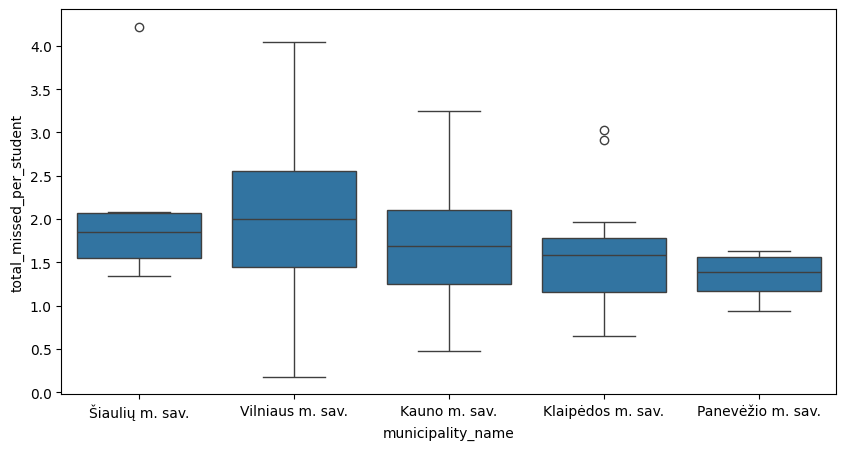

In [72]:
df_2019_oct_cities = df_2019_oct[
    df_2019_oct["municipality_name"].isin(
        [
            "Vilniaus m. sav.",
            "Kauno m. sav.",
            "Klaipėdos m. sav.",
            "Panevėžio m. sav.",
            "Šiaulių m. sav.",
        ]
    )
]

plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df_2019_oct_cities,
    x="municipality_name",
    y="total_missed_per_student",
)

<Axes: xlabel='municipality_name', ylabel='total_missed_per_student'>

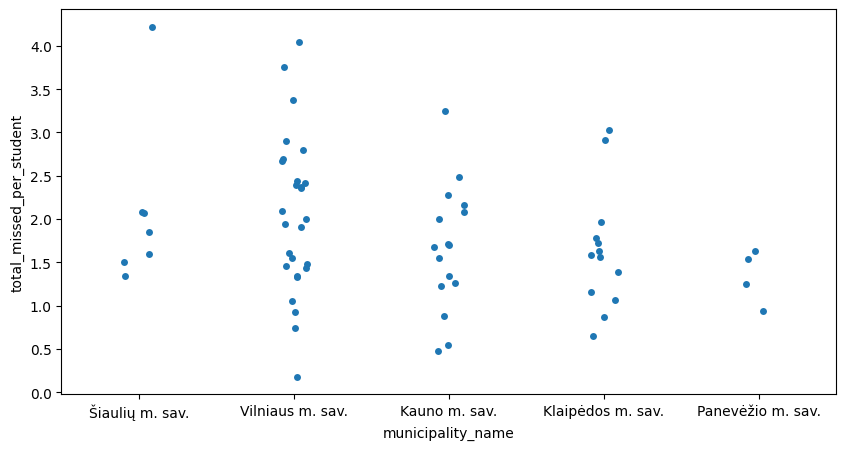

In [73]:
plt.figure(figsize=(10, 5))
sns.stripplot(
    data=df_2019_oct_cities,
    x="municipality_name",
    y="total_missed_per_student",
)

<Axes: xlabel='municipality_name', ylabel='total_missed_per_student'>

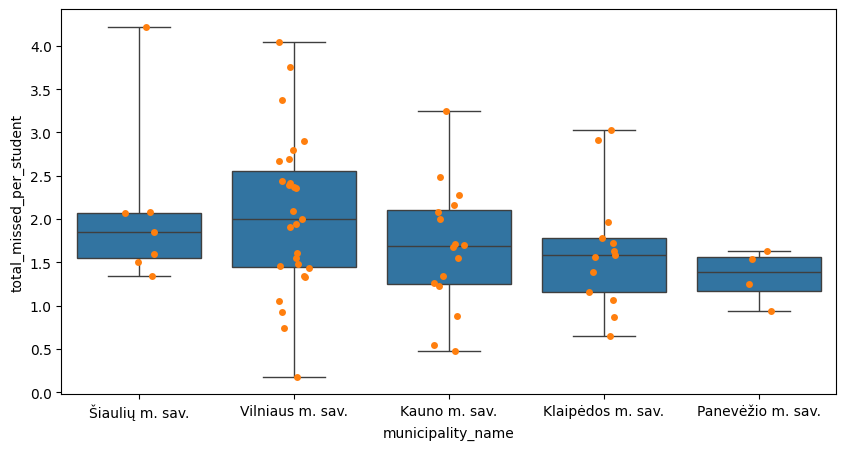

In [74]:
# combine
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df_2019_oct_cities,
    x="municipality_name",
    y="total_missed_per_student",
    whis=[0, 100],
)
sns.stripplot(
    data=df_2019_oct_cities,
    x="municipality_name",
    y="total_missed_per_student",
)

### Jointplots



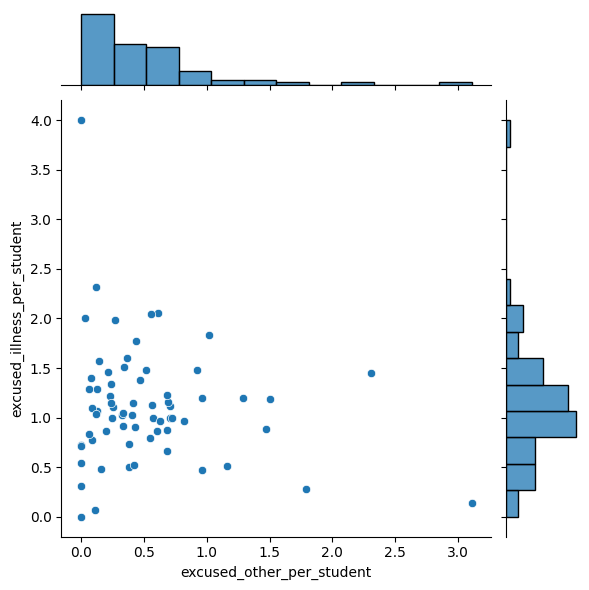

In [75]:
sns.jointplot(
    data=df_2019_oct_cities,
    x="excused_other_per_student",
    y="excused_illness_per_student",
)

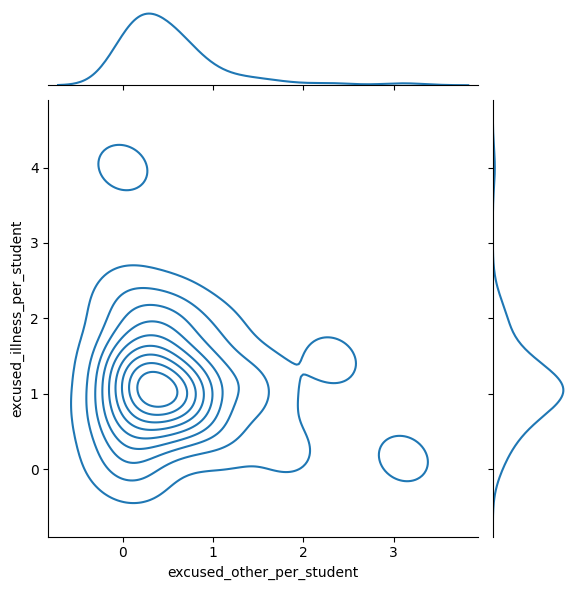

In [76]:
# aka contour plot
sns.jointplot(
    data=df_2019_oct_cities,
    x="excused_other_per_student",
    y="excused_illness_per_student",
    kind="kde",
)

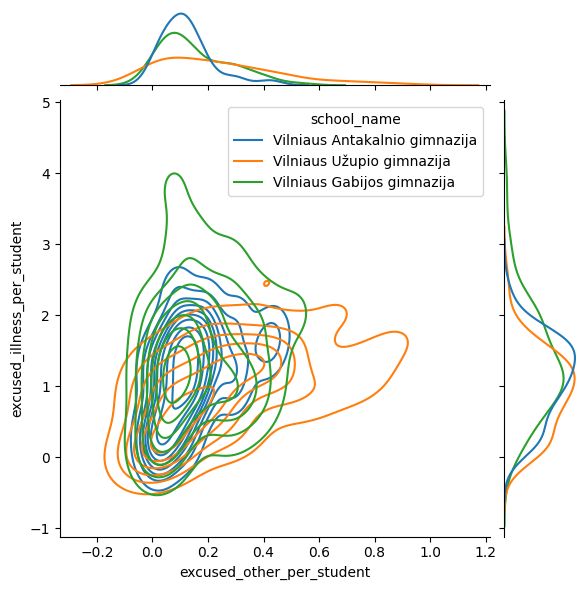

In [77]:
sns.jointplot(
    data=df_three_schools,
    x="excused_other_per_student",
    y="excused_illness_per_student",
    kind="kde",
    hue="school_name",
)

Contrast this plot with the scatter plot we made before on the same dataframe - at least to me the contour plot is easier to look at.


### Lineplot with Confidence Interval


What if we're plotting against time something that has variance? There are several plots for that.


<Axes: xlabel='year', ylabel='total_missed_per_student'>

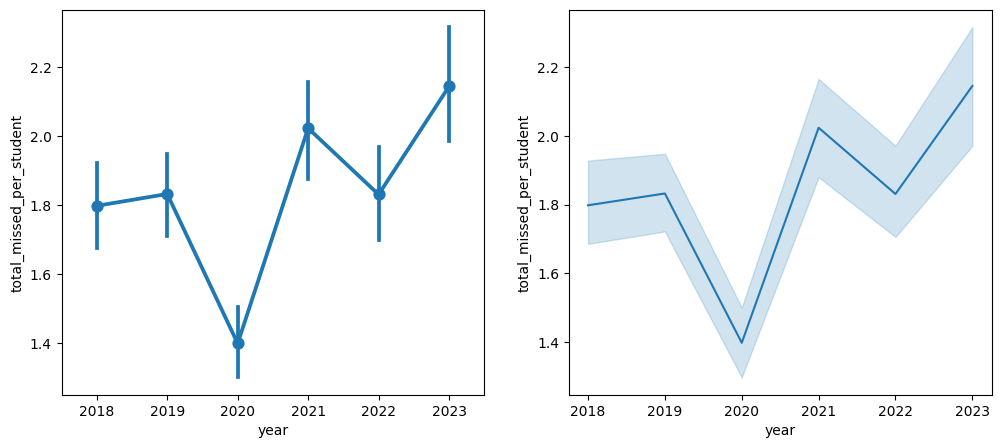

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.pointplot(data=df_oct_all_years, x="year", y="total_missed_per_student", ax=axs[0])
sns.lineplot(
    data=df_oct_all_years,
    x="year",
    y="total_missed_per_student",
    errorbar="ci",
    ax=axs[1],
)

<Axes: xlabel='year', ylabel='total_missed_per_student'>

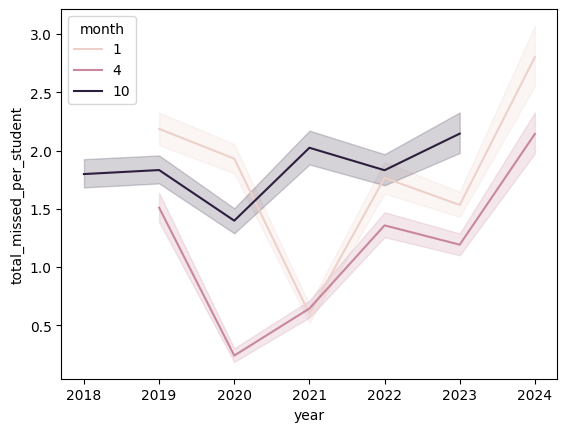

In [79]:
df_oct_jan_apr_all_years = df[df["month"].isin([10, 1, 4])]

sns.lineplot(
    data=df_oct_jan_apr_all_years,
    x="year",
    y="total_missed_per_student",
    hue="month",
    errorbar="ci",
)

At the end of the notebook make a "proper" plot that is interesting, titled, labelled, etc.

## Recap

- Use [seaborn plot gallery](https://seaborn.pydata.org/examples/index.html) for inspiration.
- There are only four key plots you need to know:
  - histogram - for plotting the distribution of a single variable
  - lineplot - for plotting how something changes across time
  - scatter plot - for plotting a relationship between two continuous variables
  - barplot - for plotting a relationship between continuous and categorical variables
  
- The rest of the plots are variations or combinations of these four key plots.
- This dataset happened to be very messy, other datasets in the course hopefully will be cleaner.

